# Feature-Based Explanations using Saliency Library

## Overview

This lab shows how to train a classification model on image data and use the Saliency library to explain the model predictions (feature attributions).

[Saliency](https://github.com/PAIR-code/saliency) is a framework-agnostic library for state-of-the-art saliency methods (XRAI, BlurIG, SmoothGrad, and more) for exlainability, developed by Google PAIR (People + AI Research) team.<br>
In this notebook, we will explore how to use Saliency for an image classification model written in TensorFlow Keras.


### Learning objectives: 
* Explore the dataset
* Build and train a custom image classification model
* Compute explanations using Saliency library
* Visualize feature attributions from Integrated Gradients and XRAI

## Setup

### Import libraries

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

os.environ["KERAS_BACKEND"] = "tensorflow"

warnings.filterwarnings("ignore")

In [2]:
import random

import keras
import keras_hub
import matplotlib.image as mpimg
import numpy as np
import saliency.core as saliency
import tensorflow as tf
from matplotlib import pyplot as plt

2025-09-05 14:00:55.642272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757080855.665046  185963 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757080855.671918  185963 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

GCS_PATTERN = "gs://asl-public/data/flowers-xai/*.tfrec"
DATA_PATH = f"gs://{BUCKET}/flowers/data"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

Run the following cell to create your Cloud Storage bucket if it does not already exist.

In [4]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET} already exists."

else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Bucket gs://takumiohym-sandbox already exists.


## Explore the Dataset
The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). This section shows how to shuffle, split, and copy the files to your GCS bucket. 

### Load, split, and copy the dataset to your GCS bucket

In [5]:
TRAINING_DATA_PATH = os.path.join(DATA_PATH, "training")
EVAL_DATA_PATH = os.path.join(DATA_PATH, "validation")
VALIDATION_SPLIT = 0.2

# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]

# Copy training files to GCS
for file in training_filenames:
    !gsutil -m cp $file $TRAINING_DATA_PATH/

# Copy eval files to GCS
for file in validation_filenames:
    !gsutil -m cp $file $EVAL_DATA_PATH/

Copying gs://asl-public/data/flowers-xai/flowers05-230.tfrec...
/ [1/1 files][  5.8 MiB/  5.8 MiB] 100% Done                                    
Operation completed over 1 objects/5.8 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers03-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers10-230.tfrec...
/ [1/1 files][  5.6 MiB/  5.6 MiB] 100% Done                                    
Operation completed over 1 objects/5.6 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers00-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers06-230.tfrec...
/ [1/1 files][  5.7 MiB/  5.

Run the following commands. You should see a number of .tfrec files in your GCS bucket at both gs://{BUCKET}/flowers/data/training and gs://{BUCKET}/flowers/data/validation

In [ ]:
!gsutil ls -l $TRAINING_DATA_PATH

In [ ]:
!gsutil ls -l $EVAL_DATA_PATH

### Create ingest functions
Let's define data ingest functions.
First we define metadata for features and labels.

In [8]:
IMAGE_SIZE = [192, 192]
BATCH_SIZE = 32

CLASSES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]

Note that here we load data from TFRecords format files using `read_tfrecord` function.<br>
It is called from `load_dataset` that builds and returns a `tf.data.Dataset` object.

For more details about TFRecords parsing, please refer to [tfrecords_tfdata.ipynb notebook](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/image_models/solutions/tfrecords_tfdata.ipynb)

In [9]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.cast(
        image, tf.float32
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def load_dataset(gcs_pattern, batch_size=32, training=True):
    filenames = tf.io.gfile.glob(gcs_pattern)
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord).batch(batch_size)
    return ds

### Visualize the examples
Let's visualize some examples from the training dataset.

I0000 00:00:1757080894.720765  185963 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


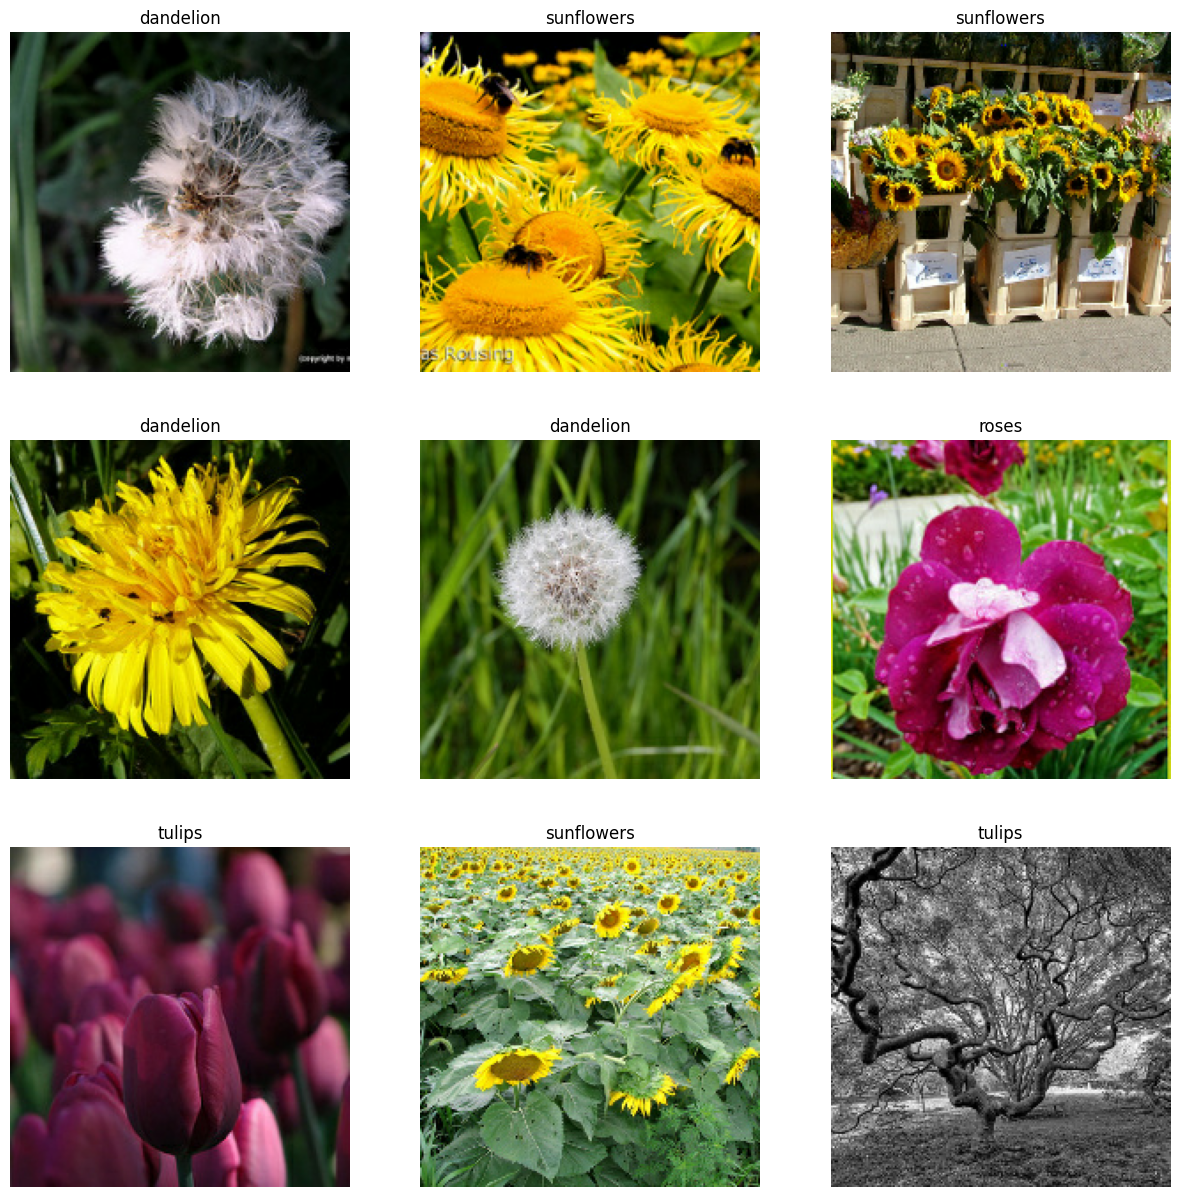

In [10]:
ROWS = 3
COLS = 3
UPSCALE_FACTOR = 5


def ShowImage(im, title="", ax=None, cmap=None):
    if ax is None:
        plt.figure()
    plt.axis("off")
    plt.imshow(im / 255, cmap=cmap)
    plt.title(title)


# Display 9 examples from the dataset
trainin_data_path = os.path.join(TRAINING_DATA_PATH, "*.tfrec")
ds = load_dataset(gcs_pattern=trainin_data_path, batch_size=9)

plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
for images, labels in ds.take(1):
    for i, (image, label) in enumerate(zip(images, labels)):
        title = CLASSES[np.argmax(label, axis=-1)]
        subplot = ShowImage(image, title, plt.subplot(ROWS, COLS, i + 1))

## Build and Train a image classification model

The code in the cell below contains the training logic. It starts by ingesting the data from GCS, then trains an image classification model using [MobileNet](https://www.kaggle.com/models/keras/mobilenetv3/keras/mobilenet_v3_large_100_imagenet_21k/1) as a feature extractor, and at last sends its output feature vector through a keras.dense layer with 5 units (one unit per label) and a softmax activation.


In [11]:
def build_model():
    backbone = keras_hub.models.Backbone.from_preset(
        "mobilenet_v3_large_100_imagenet_21k",
    )
    backbone.trainable = False

    transfer_model = keras.Sequential(
        [
            keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
            keras.layers.Rescaling(scale=1.0 / 255),
            backbone,
            keras.layers.GlobalMaxPooling2D(),
            keras.layers.Dense(
                5,
                activation="softmax",
                kernel_regularizer=keras.regularizers.l2(0.0001),
            ),
        ]
    )
    # transfer_model.build((None,) + (IMG_HEIGHT, IMG_WIDTH, 3))
    transfer_model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
        jit_compile=True,
    )

    return transfer_model

In [12]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobile_net_backbone             │ (None, 6, 6, 960)      │     2,996,352 │
│ (MobileNetBackbone)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 960)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

### Train the model locally 

In [13]:
BATCH_SIZE = 32
NUM_EPOCHS = 15

train_ds = load_dataset(
    gcs_pattern=os.path.join(TRAINING_DATA_PATH, "*.tfrec"),
    batch_size=BATCH_SIZE,
)
eval_ds = load_dataset(
    gcs_pattern=os.path.join(EVAL_DATA_PATH, "*.tfrec"), training=False
)

history = model.fit(
    train_ds,
    validation_data=eval_ds,
    epochs=NUM_EPOCHS,
)

Epoch 1/15


I0000 00:00:1757080906.636058  191894 service.cc:148] XLA service 0x7efad00025d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757080906.636113  191894 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757080907.786879  191894 cuda_dnn.cc:529] Loaded cuDNN version 90300


      6/Unknown 12s 24ms/step - accuracy: 0.2081 - loss: 6.4263

I0000 00:00:1757080912.193677  191894 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.5423 - loss: 3.0570 - val_accuracy: 0.8237 - val_loss: 0.9124
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8135 - loss: 0.9559 - val_accuracy: 0.8654 - val_loss: 0.6462
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8618 - loss: 0.6447 - val_accuracy: 0.9057 - val_loss: 0.3865
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8992 - loss: 0.4337 - val_accuracy: 0.9016 - val_loss: 0.3583
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9159 - loss: 0.3209 - val_accuracy: 0.8965 - val_loss: 0.3849
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9275 - loss: 0.2501 - val_accuracy: 0.8858 - val_loss: 0.4447
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9328 - loss: 0.2295 - val_accuracy: 0.9185 - val_loss: 0.3016
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9204 - loss: 0.2778 - val_accuracy: 0.9

## Check model prediction

Now that our image classification model has been trained, let's choose a target image we want to explain, and check the prediction result.

In [14]:
# Wrap inference in tf.function for acceleration


@tf.function
def predict(inputs):
    return model(inputs)

In [30]:
for d in eval_ds.shuffle(1000).take(1):
    image = d[0][0]

result = predict(keras.ops.expand_dims(image, 0))
prediction_class = keras.ops.argmax(result, axis=-1).numpy()[0]

Here, we'll prepare several helper functions to aid in visualizing the image and explanations later.

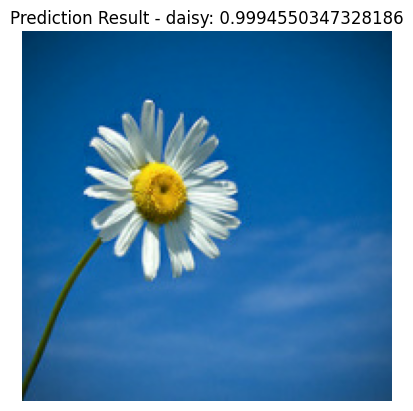

In [31]:
ShowImage(
    image,
    title=f"Prediction Result - {CLASSES[prediction_class]}: {result[0][prediction_class].numpy()}",
)

## Explanation with Saliency library
Now let's use the [Saliency](https://github.com/PAIR-code/saliency) library to create explanations. We'll focus on two techniques: Integrated Gradients and XRAI, while the library support other saliency explanation techniques. <br>

Saliency techniques are a set of methods that link a deep neural network's prediction to the inputs that influence that prediction, by inspecting the internals of the model. <br>
For image models, saliency methods return an importance score for each pixel or region, creating a saliency mask, or sensitivity mask, that highlights the most influential parts of the image.

### Setup the `call_model_function`
To use saliency techniques, we need to define how to compute the necessary *internals* required by the methods. <br>
We write that information in the `call_model_function`.

Integrated Gradients and XRAI use gradients of model's prediction (a target class probability) with respect to inputs (image pixels). We'll discuss more in detail. (Note that the gradients requires here are not the gradients of *loss* with respect to each *parameters* which are used in gradient descent optimization.)<br>
In TensorFlow, we can conveniently use tf.GradientTape to compute these gradients.<br>

The function returns the information in a dictionary with specific keys. For Integrated Gradients and XRAI, we returns the gradients of output w.r.t. inputs along with the `saliency.base.INPUT_OUTPUT_GRADIENTS` key. <br>
Please note that the shape of the gradients value need to be the same as the image tensor $(h \times w \times d)$.

Other methods may require different types of *internals* and corresponding keys. Please refer to the Github repository for details. (e.g. [Grad-CAM](https://arxiv.org/abs/1610.02391) requires [`CONVOLUTION_LAYER_VALUES` and `CONVOLUTION_OUTPUT_GRADIENTS` keys](https://github.com/PAIR-code/saliency/blob/7b72b673fde6680180befd277c1890d4a9de4b48/saliency/core/grad_cam.py#L67).)

While we use TensorFlow example here, please remember that the Saliency library is designed to work with various machine learning frameworks, and it works as long as it returns the necessary information in required shapes.

In [32]:
class_idx_str = "class_idx_str"

call_model_args = {class_idx_str: prediction_class}


def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx = call_model_args[class_idx_str]
    images = keras.ops.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        tape.watch(images)
        output_layer = predict(images)
        output_layer = output_layer[:, target_class_idx]
        gradients = np.array(tape.gradient(output_layer, images))
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

### Integrated Gradients

Let's start with the Integrated Gradients (IG) method, an explainable AI technique described in the paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365). 

IG is a saliency method that utilizes gradients of the model's output with respect to its inputs to generate a saliency mask.
However, instead of using the vanilla gradients, IG involves these additional steps:
1. Create series of image perturbations by interpolating between base image (usually a black image) and the target image. The number of the perturbations is determined by the chosen interpolation step number. 
2. Compute gradients of the models's output with respect to each pixel for all image perturbations. This results in a set of gradients with dimensions $(n \times h \times w \times d)$ , where n is the number of pertubations and h, w, d are image hight, width and depth (or channel) respectively.
3. Integrate the gradients over all interpollations. This returns $(h \times w \times d)$ shaped tensor which corresponds with the original image shape. This tensor is later reduced to $(h \times w)$ for visualization purpose.


With the Saliency library, we don't need to implement these steps from scratch. 

First, let's define the black baseline image for the step 1.

In [33]:
# Baseline is a black image.
baseline = np.zeros(image.shape)

Now, let's generate an Integrated Gradients mask.

We can simply call `saliency.IntegratedGradients().GetMask` method providing the following arguments:
- `x_value`: The target image.
- `call_model_function`: The `call_model_function` configured above.
- `call_model_args`: Necessary arguments for your `call_model_function`.
- `x_steps`: The number of interpolation steps for Integrated Gradients. More steps generally lead to smoother results, but may increase computation time.
- `x_baseline`: The baseline image (A black image here)

Also, we can use `GetSmoothedMask` to get smoothed mask, as introduced in [SmoothGrad: removing noise by adding noise](https://arxiv.org/pdf/1706.03825.pdf) paper.<br>
This helps generate smoother masks by approximating the local pixel average, reducing the effect of noisy pixels.

In [34]:
integrated_gradients = saliency.IntegratedGradients()

vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
    x_value=image.numpy(),
    call_model_function=call_model_function,
    call_model_args=call_model_args,
    x_steps=25,
    x_baseline=baseline,
)

smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
    x_value=image.numpy(),
    call_model_function=call_model_function,
    call_model_args=call_model_args,
    x_steps=25,
    x_baseline=baseline,
)

Keep in mind that these methods return 3D tensors $(h \times w \times d)$ which is the same shape as the input image.<br>
For visualization purpose, we convert them to 2D grayscale image $(h \times w)$ using Saliency's convenient `VisualizeImageGrayscale` function.

In [35]:
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(
    vanilla_integrated_gradients_mask_3d
)

smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(
    smoothgrad_integrated_gradients_mask_3d
)

Let set up matplot lib figures and visualize the explanations.

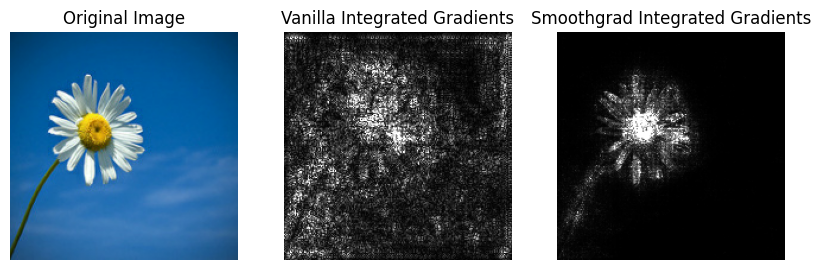

In [36]:
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 10
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowImage(image, title="Original Image", ax=plt.subplot(ROWS, COLS, 1))
ShowImage(
    vanilla_mask_grayscale,
    title="Vanilla Integrated Gradients",
    ax=plt.subplot(ROWS, COLS, 2),
    cmap=plt.cm.gray,
)
ShowImage(
    smoothgrad_mask_grayscale,
    title="Smoothgrad Integrated Gradients",
    ax=plt.subplot(ROWS, COLS, 3),
    cmap=plt.cm.gray,
)

### XRAI
Now let's take a look at another saliency method, XRAI, introduced in the [XRAI: Better Attributions Through Regions](https://arxiv.org/abs/1906.02825) paper. 

XRAI builds upon Integrated Gradients while offering key improvements:
- **Multiple Baselines**: XRAI uses both black and white baseline images to avoid biases that might arise from using a single, specific input. This prevents issues like IG potentially failing to highlight a black object if presented with a black baseline.
- **Region-Based Attribution**: XRAI integrates segmentation masks to produce regional saliency masks, which can provide more intuitive explanations than pixel-level maps.

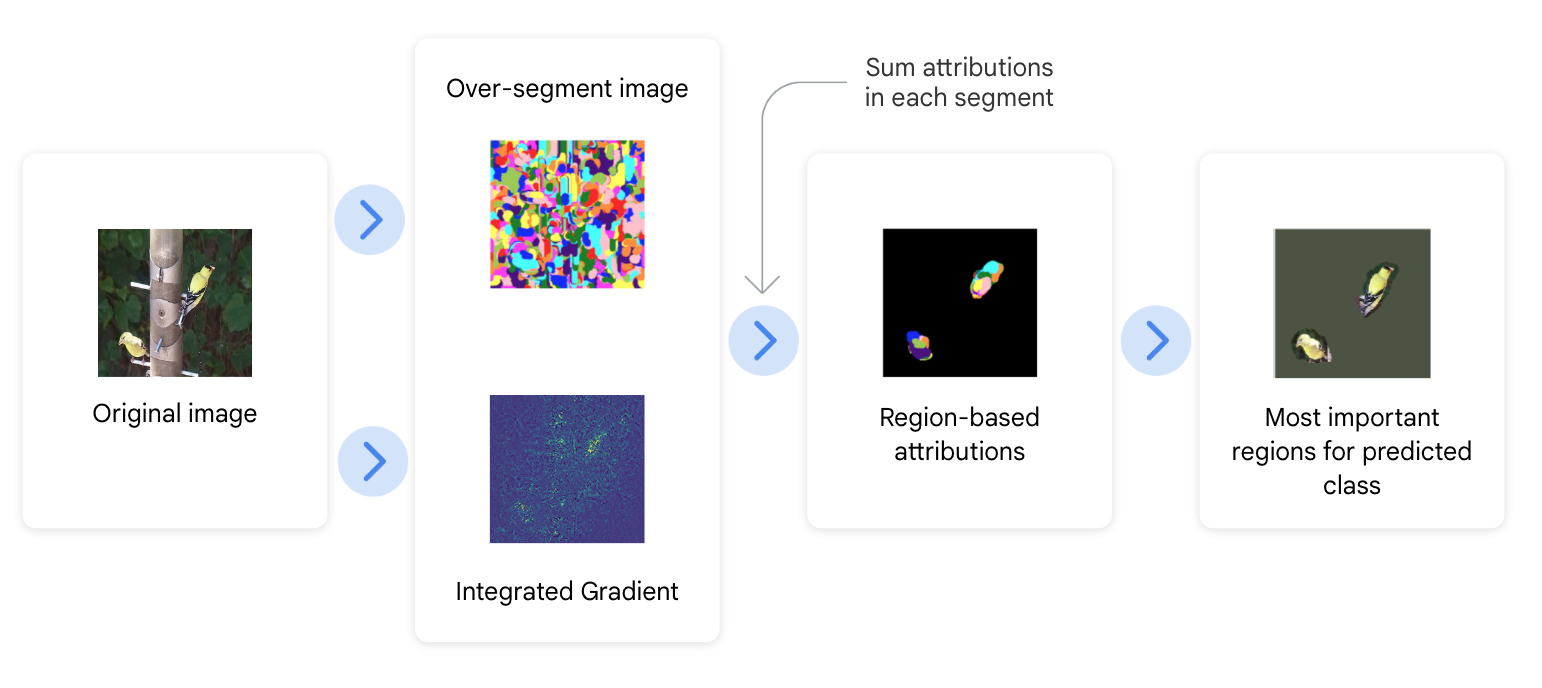

The `GetMask` method is similar to that of Integrated Gradients method.<br>
However, you don't need to provide a baseline image, as XRAI utilizes both white and black baselines by default. <br>

You can control the step size for the internal Integrated Gradients calculatin within XRAI, by passing `extra_parameters=saliency.XRAIParameters(steps=<step size>)` (the default step size is `100`).

In [37]:
xrai_object = saliency.XRAI()

xrai_attributions = xrai_object.GetMask(
    x_value=image.numpy(),
    call_model_function=call_model_function,
    call_model_args=call_model_args,
    # extra_parameters=saliency.XRAIParameters(steps=25), # Optional
)

Let's visualize the saliency mask.

XRAI returns an image-shaped saliency mask.<br>
We can filter based on heatmap values, to focus on the most important regions. Here we isolate the top 30% of image regions.

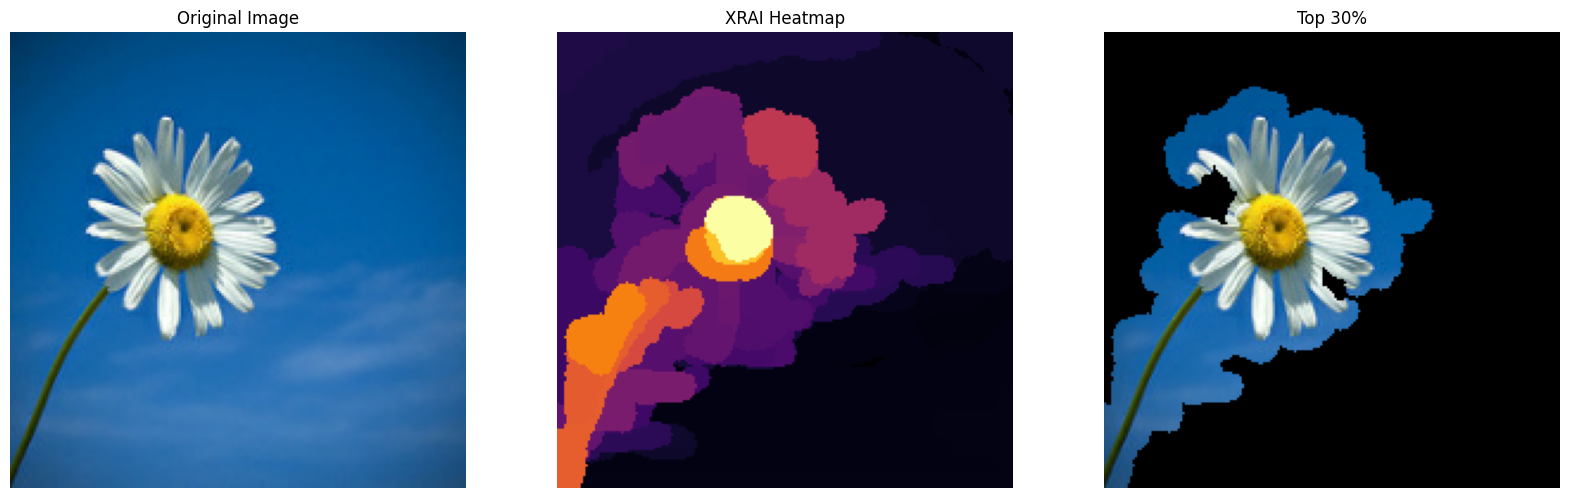

In [38]:
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(image, title="Original Image", ax=plt.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowImage(
    xrai_attributions,
    title="XRAI Heatmap",
    ax=plt.subplot(ROWS, COLS, 2),
    cmap="inferno",
)

# Show most salient 30% of the image
mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
im_mask = np.array(image)
im_mask[~mask] = 0
ShowImage(im_mask, title="Top 30%", ax=plt.subplot(ROWS, COLS, 3))

## What's next?

To learn more about Saliency library and AI Explanations, check out the resources here.

* [Saliency](https://github.com/PAIR-code/saliency)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)
* [XRAI paper](https://arxiv.org/abs/1906.02825)

Copyright 2025 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License